# Variational Autoencoder (VAE) in JAX (+ Flax + Optax + Distrax)

## Load Dataset

Datasets can be loaded using any framework. I am using `torchvision` here for convenience.

In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from PIL import Image

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./datasets",
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    ),
    batch_size=32,
    shuffle=True,
)

## Create Model

In [2]:
from typing import Any
import jax
import jax.numpy as jnp
import jax.random as jrand
import flax.linen as nn
import optax
import distrax
from tqdm.auto import tqdm

class Encoder(nn.Module):
    data_dim: int
    latent_dim: int

    @nn.compact
    def __call__(self, x) -> Any:
        h = nn.Sequential([nn.Dense(512), nn.relu, nn.Dense(256), nn.relu])(x)
        mu = nn.Dense(self.latent_dim)(h)
        log_var = nn.Dense(self.latent_dim)(h)
        return mu, log_var


class Decoder(nn.Module):
    data_dim: int
    latent_dim: int

    @nn.compact
    def __call__(self, x) -> Any:
        h = nn.Sequential(
            [nn.Dense(256), nn.relu, nn.Dense(512), nn.relu, nn.Dense(self.data_dim)]
        )(x.reshape((x.shape[0], self.latent_dim)))
        return h


class VAE(nn.Module):
    data_dim: int
    latent_dim: int

    def setup(self) -> None:
        self.encoder = Encoder(data_dim=self.data_dim, latent_dim=self.latent_dim)
        self.decoder = Decoder(data_dim=self.data_dim, latent_dim=self.latent_dim)
        self.prior = distrax.Normal(0.0, 1.0)

    def reparameterize(self, mu, logvar, key):
        std = jnp.exp(0.5 * logvar)
        eps = jrand.normal(key=key, shape=std.shape, dtype=std.dtype)
        return mu + eps * std

    def __call__(self, x, key) -> Any:
        mu, logvar = self.encoder(x.reshape((x.shape[0], 784)))
        z = self.reparameterize(mu, logvar, key)
        q0 = distrax.Normal(loc=mu, scale=jnp.exp(0.5 * logvar))
        log_prior_z = self.prior.log_prob(z).sum(-1)
        log_q_z = q0.log_prob(z).sum(-1)
        return self.decoder(z), log_q_z - log_prior_z

## Initialize Model and Setup Loss

In [3]:
# Create and split an RNG Key
key, subkey = jrand.split(jrand.PRNGKey(0))

# Create VAE model
model = VAE(data_dim=784, latent_dim=20)

# Initialize model
vae_params = model.init(key, jnp.ones((32, 1, 28, 28)), subkey)

# Create optimizer and initialize optimizer state
tx = optax.adam(learning_rate=1e-3)
opt_state = tx.init(vae_params)

**NOTE**: Flax models do not keep the parameters inside. They called by `model.apply` which takes the model params as an argument. In our case, we also need randomness to sample from the posterior distribution, so we also need to pass the PRNG `key` to the model. This is different from PyTorch models that have parameters inside the module and a global PRNG state.

In [4]:
# Create a loss function and its jitted version
def loss(params, x, key):
    x_logits, reg = model.apply(params, x, key)
    loss = (
        optax.sigmoid_binary_cross_entropy(logits=x_logits, labels=x.reshape(x_logits.shape)).sum() + reg.sum()
    ) / x_logits.shape[0]
    return loss

@jax.jit
def jitted_loss(params, x, key):
    return loss(params, x, key)

# Create a wrapper that computes the loss and its gradient
loss_grad_fn = jax.value_and_grad(loss)
jitted_loss_grad_fn = jax.value_and_grad(jitted_loss)

## Train Model

In [5]:
n_epochs = 10

for i in tqdm(range(n_epochs)):
    pbar = tqdm(dataloader, leave=False)
    for x_batch, _ in pbar:
        key, subkey = jrand.split(key)

        # Get a batch of data
        x_batch = jnp.asarray(x_batch)

        # Compute loss and grads
        # NOTE: try using the loss_grad_fn here to notice speedup provided by jit
        loss_val, grads = jitted_loss_grad_fn(vae_params, x_batch, key)

        # Get param updates from optimizer
        updates, opt_state = tx.update(grads, opt_state)

        # Apply updates to model params
        vae_params = optax.apply_updates(vae_params, updates)
        
        pbar.set_description(f"Loss: {loss_val:.2f}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

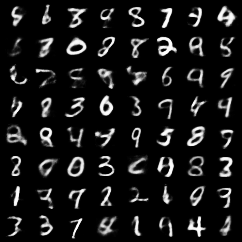

In [6]:
# Create a function to draw samples from the model
# NOTE: Functions outside the model must take the model object
# as one of their arguments
def sample_fn(model, code):
    return nn.sigmoid(model.decoder(code))

# Sample latent vectors from N(0, 1)
key, subkey = jrand.split(key)
code = jrand.normal(subkey, shape=(64, 20))

# Draw samples by calling the sample_fn we just defined
samples = model.apply(vae_params, code, method=sample_fn).reshape(64, 1, 28, 28)

# Convert to image
img_arr = make_grid(torch.from_numpy(np.array(samples * 255).astype(jnp.uint8))).numpy()
Image.fromarray(np.transpose(img_arr, (1, 2, 0)))